<a href="https://colab.research.google.com/github/yukliio/stemcamp.aistation/blob/main/lab_notebooks/playground/playground_Tumor_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement: 🧠 Helping Doctors Find Brain Tumors with AI 🤖

Doctors in small towns or villages often don’t have fancy computers or fast internet. They’ve asked for a smart tool that can help them find brain tumors using MRI pictures — even if there’s no X-ray!

### 💡 How It Works:
- The tool uses **Random Forest** 🌳🌳🌳
- It looks at brain scan images 🖼️ and figures out if there is a tumor, and what kind it might be.

### 🧪 It Should Detect:
1. 🧠 **Glioma** – a tumor that grows inside the brain tissue  
2. 🧠 **Meningioma** – a tumor near the outside of the brain  
3. 🧠 **Pituitary Tumor** – a tumor at the base of the brain  
4. ✅ **No Tumor** – everything looks normal!

### Let's Start Building!

# ⭐ Step 0: download our dataset.

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yukliio","key":"edbf83c0bd6f85a815eb0d6262aec67d"}'}

In [ ]:
# create a kaggle folde
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -al ~/.kaggle

total 16
drwxr-xr-x 2 root root 4096 Jun 19 12:48 .
drwx------ 1 root root 4096 Jun 19 12:48 ..
-rw------- 1 root root   63 Jun 19 12:48 kaggle.json


In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --force
!unzip -q brain-tumor-mri-dataset.zip -d brain-tumor-mri


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 69% 103M/149M [00:00<00:00, 527MB/s] 
100% 149M/149M [00:00<00:00, 543MB/s]


# ⭐ Step 1: Prepare Our Data for the AI to Train 🧠🤖

Before our AI can learn how to find brain tumors in MRI pictures, we have to **prepare the images** so that a computer can understand them.

🧍‍♂️ People have eyes, but computers don’t!  
💻 Computers understand images through **numbers**, not pictures.

---

## 🛠️ What This Code Does:

1. 📏 **Resize** every image to **128 x 128 pixels** so they all look the same to the computer.
2. 📄 **Flatten** the images — this means we **turn a 2D image into 1 long list of numbers**.
   - Computers need everything to be in a straight line (1D), not a grid (2D)!
   - Example: If an image is 128x128 pixels, flattening it gives **16,384 numbers** (128 × 128).
   - [[ 10, 20, 30],
      [ 40, 50, 60],
      [ 70, 80, 90]] (2D) ---> [10, 20, 30, 40, 50, 60, 70, 80, 90] (Flattened 1D)

In [ ]:
from PIL import Image
import numpy as np
import os

# all images the same size: 128 x 128 pixels
image_size = (128, 128)

def load_and_preprocess(image_folder):
    data = []
    labels = []

    for label_name in os.listdir(image_folder):
        label_folder = os.path.join(image_folder, label_name)
        for image_file in os.listdir(label_folder):
            img_path = os.path.join(label_folder, image_file)
            img = Image.open(img_path).convert('L')

            # ✂️ Resize the image to 128 x 128 pixels [WRITE CODE UNDER HERE]
            img = img.resize(image_size)

            # 🔢 Turn the image into a big list of numbers (flatten it) [WRITE CODE UNDER HERE]
            img_array = np.array(img).flatten()

            data.append(img_array)
            labels.append(label_name)

    # Give back the data and labels so we can use them
    return np.array(data), np.array(labels)

train_dir = "/content/brain-tumor-mri/Training"
# Load and process the training images
print("📥 Loading training images...")
X_train, y_train = load_and_preprocess(train_dir)

# Show how many images and how big each one is
print("✅ X_train shape (images):", X_train.shape) # the number should be (5712, 16384) since 128 * 128 = 16384!
print("✅ y_train shape (labels):", y_train.shape)

print("\n📥 Loading testing images...")
X_test, y_test = load_and_preprocess('/content/brain-tumor-mri/Testing')
print("🎉 All images are loaded and ready for the AI to learn!")

📥 Loading training images...
✅ X_train shape (images): (5712, 16384)
✅ y_train shape (labels): (5712,)

📥 Loading testing images...
🎉 All images are loaded and ready for the AI to learn!


# ⭐ Step 2: Let's Look at Some Brain Scan Images!

Now that our AI has its training images loaded, let's look at what those brain scans actually look like!

In this step, we'll use Python code to show **25 random MRI images** from our dataset. Each image will include a label that tells us what kind of brain tumor it is — or if it's a healthy brain with no tumor.


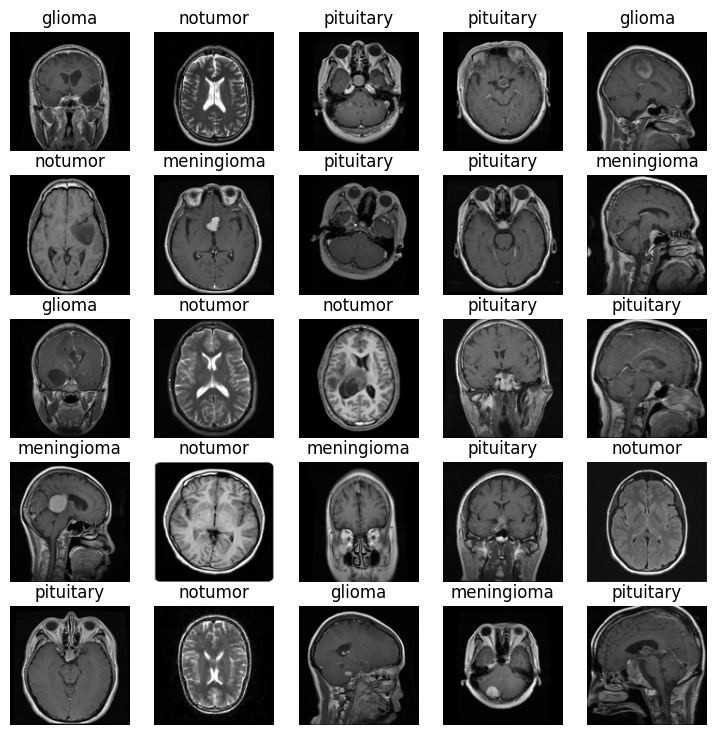

In [ ]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
random.seed(10)

fig = plt.figure(figsize=(9, 9))

# ✖️ Set up a grid to show 25 images
rows, cols = 5,5

for i in range(1, rows * cols + 1):
    random_index = random.randint(0, len(X_train) - 1)

    image = X_train[random_index]
    label = y_train[random_index]

    fig.add_subplot(rows, cols, i)

    # Show the image (reshape it back to 128x128)
    plt.imshow(image.reshape(128, 128), cmap="gray")
    plt.title(label)

    plt.axis("off")


# ⭐ Step 3: Training Our Brain Tumor AI with a Random Forest!

Now that we've prepared our images and looked at what they represent, it's time to **train our AI model** to recognize brain tumors! 🎓🧠

We're using something called a **Random Forest**. Let’s break it down:

---

### 🤔 What is a Random Forest?

A **Random Forest** is a type of AI model made up of many **decision trees**. Think of it like this:

- 🌲 Each tree is like a small "expert" that makes guesses based on what it sees.
- 🌳 When we put lots of trees together, they vote on what the answer should be.
- ✅ The final answer is based on the **majority vote** from all the trees — like teamwork!

This helps the model be more accurate and less likely to get tricked by strange or unusual images.

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1280/0*VdemgOqLxWHyJEH3" width="500"/>
</p>

 **n_estimators** just means we have **25 trees** to help us make predictions. The more trees, more more decisions the AI will have to make before determining what type of brain tumor it is.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

brainTumor_AI = RandomForestClassifier(n_estimators=25, criterion='entropy', random_state =0)

# 👩‍🏫 teach the AI based off of our training data [WRITE CODE UNDER HERE]
brainTumor_AI.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', n_estimators=25, random_state=0)

We test the AI’s guesses on new x-rays and see how accurate it is using a confusion matrix.

What’s a Confusion Matrix? ❓
It’s a chart that helps us see how well our AI is doing by comparing its guesses to the real answers.

<p align="center">
  <img src="https://cdn.prod.website-files.com/660ef16a9e0687d9cc27474a/662c42677529a0f4e97e4f96_644aea65cefe35380f198a5a_class_guide_cm08.png" width="500"/>
</p>



Accuracy of Random Forest brain tumor detection model: 93.59%


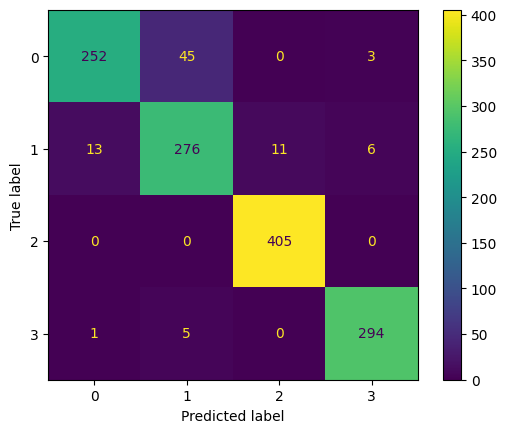

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Step 1: Make predictions
y_pred = brainTumor_AI.predict(X_test)

# Step 2: Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 3: Let's see the  results!
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(f"Accuracy of Random Forest brain tumor detection model: {round(accuracy_score(y_test, y_pred) * 100, 2)}%")

# ⭐ Step 4: Did Our AI Get It Right?

Now that we've trained our AI to detect brain tumors using Random Forest, it's time to test how well it's doing!

In this step, we:
- Ask the AI to look at brain scans it hasn't seen before
- Check how many it got right ✅
- Check how many it got wrong ❌
- Show the results in a colorful bar chart!


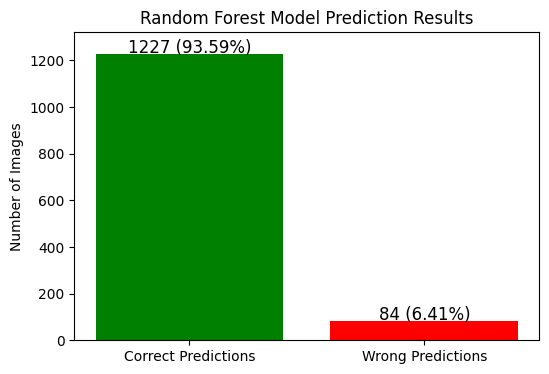

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 🧮 Make predictions [WRITE CODE UNDER HERE]


# Calculate number of correct and wrong predictions
correct = sum(y_pred == y_test)
wrong = sum(y_pred != y_test)

# Plot the results
plt.figure(figsize=(6,4))
plt.bar(['Correct Predictions', 'Wrong Predictions'], [correct, wrong], color=['green', 'red'])
plt.title('Random Forest Model Prediction Results')
plt.ylabel('Number of Images')
plt.ylim(0, len(y_test) + 10)

# Show the accuracy as text above the bars
accuracy = accuracy_score(y_test, y_pred)
plt.text(0, correct + 5, f"{correct} ({accuracy*100:.2f}%)", ha='center', color='black', fontsize=12)
plt.text(1, wrong + 5, f"{wrong} ({(1-accuracy)*100:.2f}%)", ha='center', color='black', fontsize=12)

plt.show()


# ⭐ Step 5: Let's See the AI in Action!

Now that we’ve trained our Random Forest model and checked the accuracy, it’s time to **VISUALLY see how our AI is doing** on real brain scan images!

### What You’ll See:

A **5×5 grid** of brain scan images

Each image shows:

- **T:** the True label (what the image actually is)
- **P:** the Predicted label (what the AI guessed)

If the prediction is:

- ✅ Correct, the title is **green**
- ❌ Wrong, the title is **red**

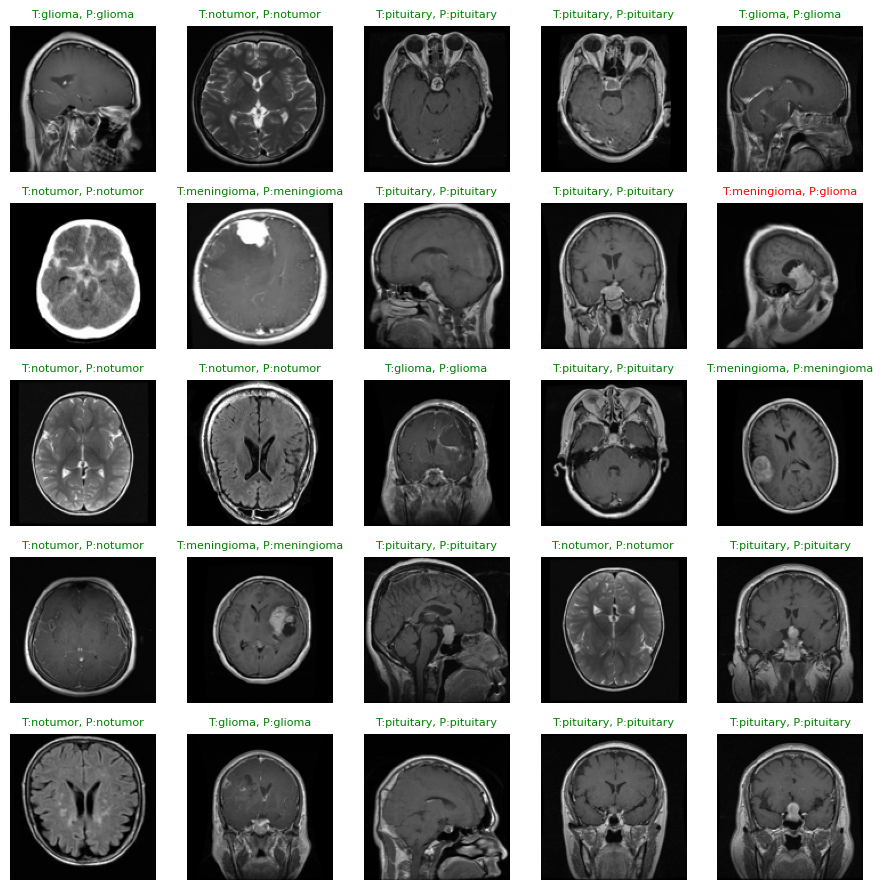

In [ ]:
import matplotlib.pyplot as plt
import random

random.seed(10)
fig = plt.figure(figsize=(9, 9))
rows, cols = 5, 5

for i in range(1, rows * cols + 1):
    random_index = random.randint(0, len(X_test) - 1)
    image = X_test[random_index]
    label = y_test[random_index]
    prediction = brainTumor_AI.predict(image.reshape(1, -1))[0]

    # 💚 Set the text green if correct. Otherwise, red [WRITE CODE UNDER HERE]!


    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(image.reshape(128, 128), cmap="gray")
    ax.set_title(f"T:{label}, P:{prediction}", fontsize=8, color=color)
    ax.axis("off")

plt.tight_layout()
plt.show()


# 🎉 Congratulations on your AI project! 🧠🤖

You did it! You built an AI that can help detect brain tumors just by looking at MRI scans — how amazing is that?! 💪